# Pairs Trading Strategy

A pairs trading strategy is a non-directional, market neutral, trading strategy that involves utilising statistical and technical analysis to generate alpha. It falls under the mean reversion, statistical arbitrage umbrella of quantitative trading strategies.

It seeks to identify 2 companies or funds with similar characteristics whose equity securities are highly correlated and currently trading at a price relationship that is out of their historical trading range. It matches a long position and a short position in two stocks with a high correlation. It is thus also referred to as statistical arbitrage. 

#### Assumptions
Two correlated assets will drift in and out of equilibrium which provides opportunities to capitalise on the arbitrage where we:

- Long the undervalued security
- Short the overvalued security

The position is open when the pair is out of an equilibrium and closed when the pair returns to an equilibrium. 

#### Goals
1. Identifying a tradable asset pair based on statistical analysis
2. Building a model that produces trading signals for our strategy that capitalises on assets trading out of equilibrium 


## Goal 1: Identifying Tradable Asset Pairs

### Acquiring Data

First we have to get historical pricing data. We create a function that returns adjusted close as our primary data in a pandas DataFrame. We'll be using historical data from 2 years prior.

In [101]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

In [2]:
# Get historical pricing data
def getHistoricalData(tickers, start, end):
    """ This function returns a pd Dataframe with all adj closing information of tickers passed"""
    s_year, s_month, s_day = start
    e_year, e_month, e_day = end
    # Getting data from Yahoo Finance
    df = yf.download(tickers, datetime(s_year, s_month, s_day), datetime(e_year, e_month, e_day), group_by='tickers')
    # Grabbing the adj close data
    df = df.iloc[:, df.columns.get_level_values(1)=='Adj Close']
    df.columns = df.columns.droplevel(1)
    
    return df

### Correlation
The goal here is to determine two different companies whose equity securities' time series are highly correlated. Qualitatively, companies from the same sector would be more than likely to produce price movements that are very similar. 

To prove correlation in their time series, we perform a statistical correlation test. In this project, we will be using a basket of 10 equities belonging to finance companies in the S&P500 index to sieve out a pair that is highly correlated.

In [18]:
tickers = ['BK', 'BAC', 'WFC', 'C', 'CFG', 'GS', 'MS', 'TFC', 'JPM', 'SCHW']
start = [2020,1,1]
end = [2022,1,1]

prices = getHistoricalData(tickers, start, end)
print(prices.shape)
prices.tail() # to show most recent data

[*********************100%***********************]  10 of 10 completed
(506, 10)


,BAC,GS,MS,JPM,TFC,WFC,SCHW,BK,CFG,C
Date,,,,,,,,,,
2021-12-27,44.639999,388.040009,99.705193,157.217621,58.459999,48.552006,85.820000,58.179127,46.844635,60.176029
2021-12-28,44.700001,387.609985,99.278168,157.694748,58.700001,48.203568,85.500000,58.119473,46.943878,60.146259
2021-12-29,44.630001,386.200012,98.046753,157.615234,58.779999,48.233437,84.959999,58.029999,46.943878,60.066887
2021-12-30,44.529999,385.519989,98.116264,157.535706,58.500000,47.884998,84.480003,57.632332,46.914108,59.957748
2021-12-31,44.490002,382.549988,97.480698,157.406494,58.549999,47.765533,84.099998,57.741692,46.894257,59.918060


In [19]:
# Correlation Matrix
corr_matrix = prices.corr()
corr_matrix

,BAC,GS,MS,JPM,TFC,WFC,SCHW,BK,CFG,C
BAC,1.000000,0.966947,0.945820,0.982982,0.960068,0.917290,0.976238,0.979189,0.971718,0.855751
GS,0.966947,1.000000,0.991522,0.966236,0.919023,0.842445,0.980013,0.946170,0.948555,0.795330
MS,0.945820,0.991522,1.000000,0.946966,0.900163,0.795533,0.971031,0.929386,0.932333,0.752516
JPM,0.982982,0.966236,0.946966,1.000000,0.979157,0.900209,0.971439,0.948094,0.989179,0.893760
TFC,0.960068,0.919023,0.900163,0.979157,1.000000,0.872719,0.936508,0.925322,0.986976,0.896251
WFC,0.917290,0.842445,0.795533,0.900209,0.872719,1.000000,0.851796,0.920808,0.868306,0.887361
SCHW,0.976238,0.980013,0.971031,0.971439,0.936508,0.851796,1.000000,0.952721,0.962274,0.781994
BK,0.979189,0.946170,0.929386,0.948094,0.925322,0.920808,0.952721,1.000000,0.931296,0.820189
CFG,0.971718,0.948555,0.932333,0.989179,0.986976,0.868306,0.962274,0.931296,1.000000,0.887356
C,0.855751,0.795330,0.752516,0.893760,0.896251,0.887361,0.781994,0.820189,0.887356,1.000000


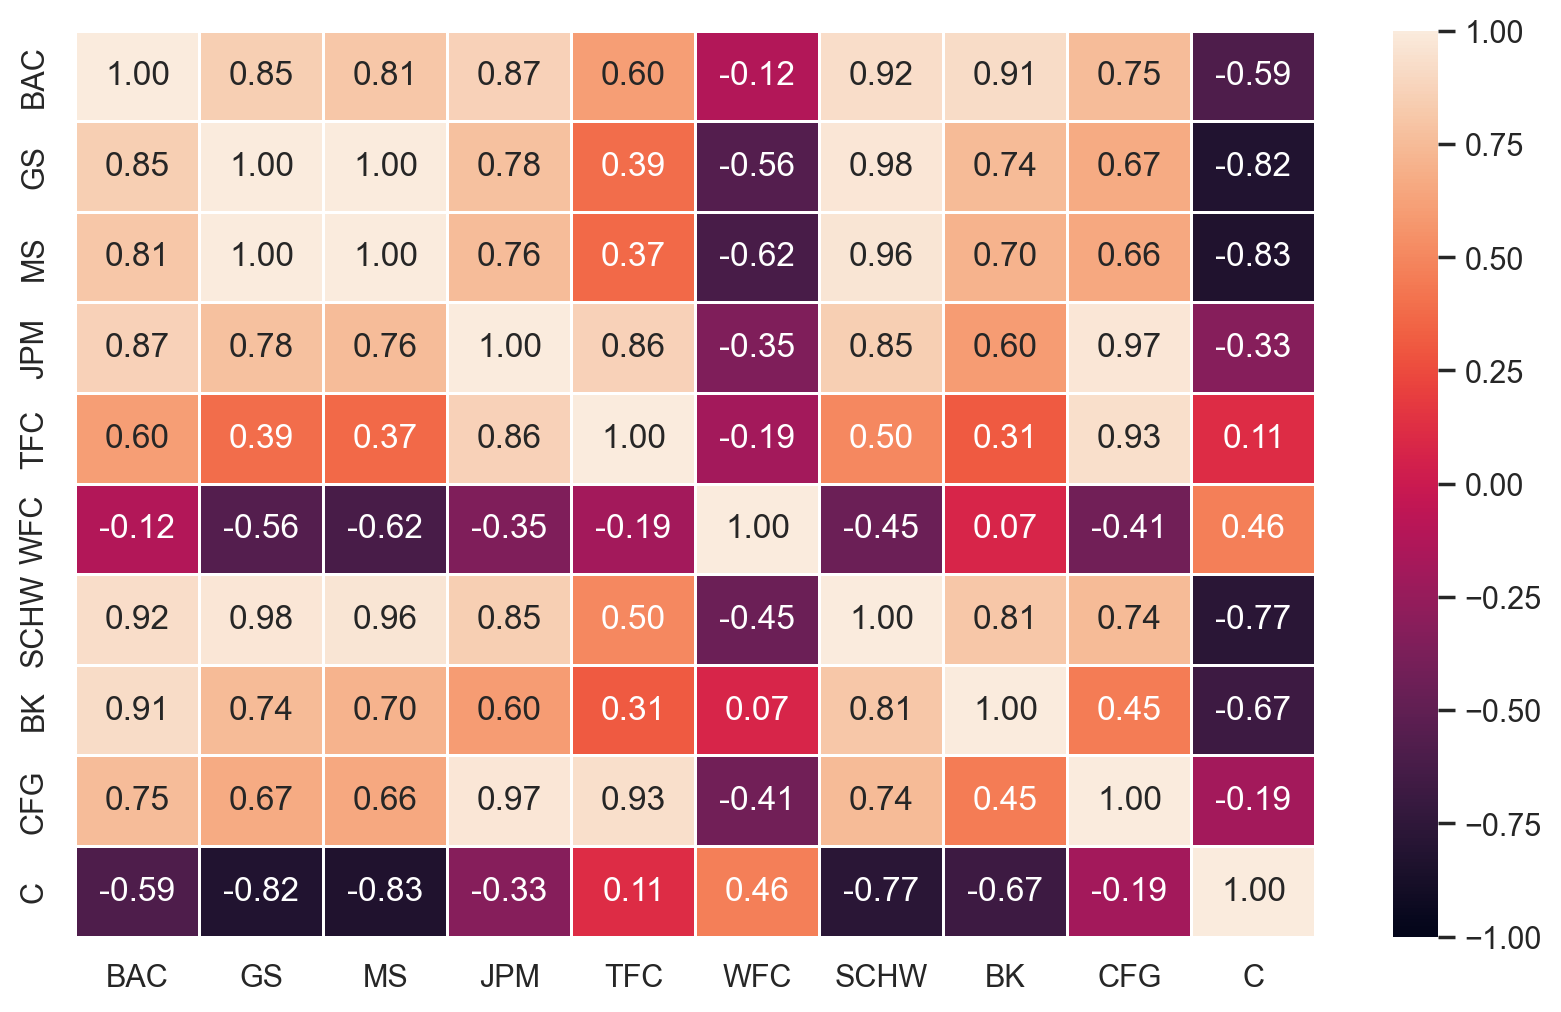

In [20]:
# Printing correlation matrix out as a heatmap
plt.figure(figsize=(10, 6), dpi=200)
sb.heatmap(corr_matrix.corr(), vmin = -1, vmax = 1, linewidths = 1, annot = True, fmt='.2f');

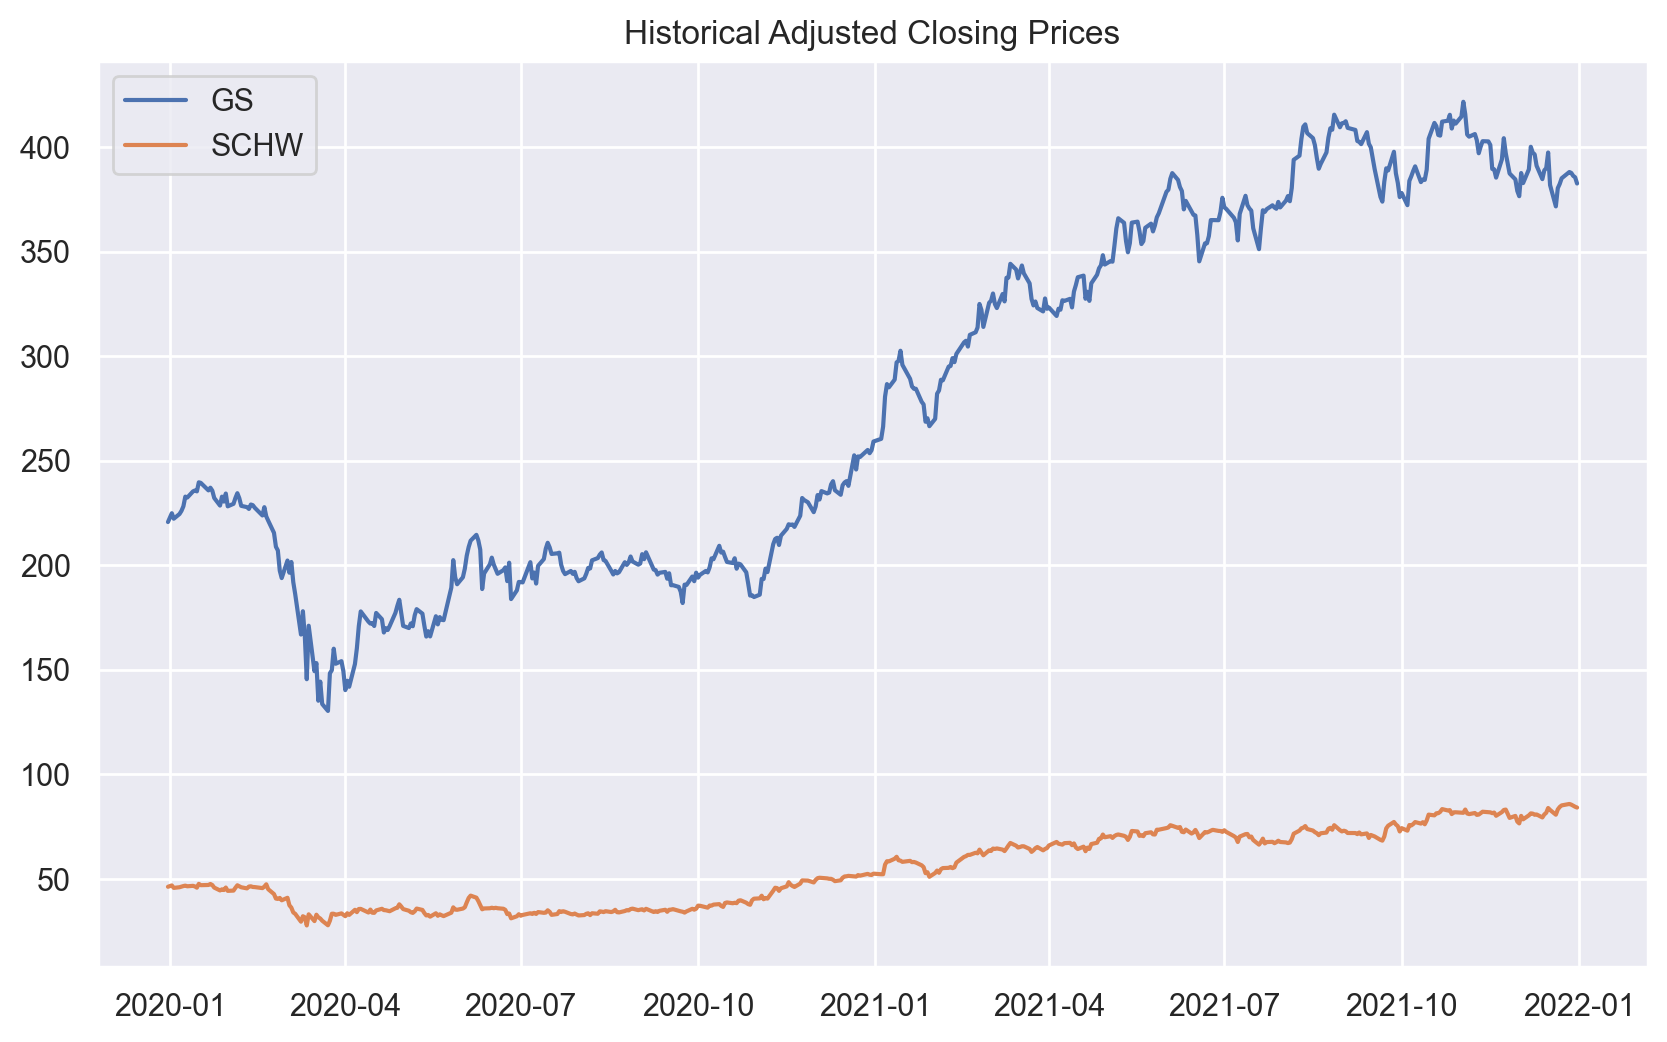

In [56]:
# High Correlation between GS and SCHW of ~ 0.98
plt.figure(figsize=(10, 6), dpi=200)
GS = prices['GS']
SCHW = prices['SCHW']
plt.plot(GS, label = 'GS')
plt.plot(SCHW, label = 'SCHW')
plt.title('Historical Adjusted Closing Prices')
plt.legend()
plt.show();

### Spread

The alpha generating piece of pairs trading is when the spread between  two assets revert to a mean over a time series. We will long the spread (long GS, short SCHW) when the spread is small and short the spread (short GS, long SCHW) when the the spread is large.

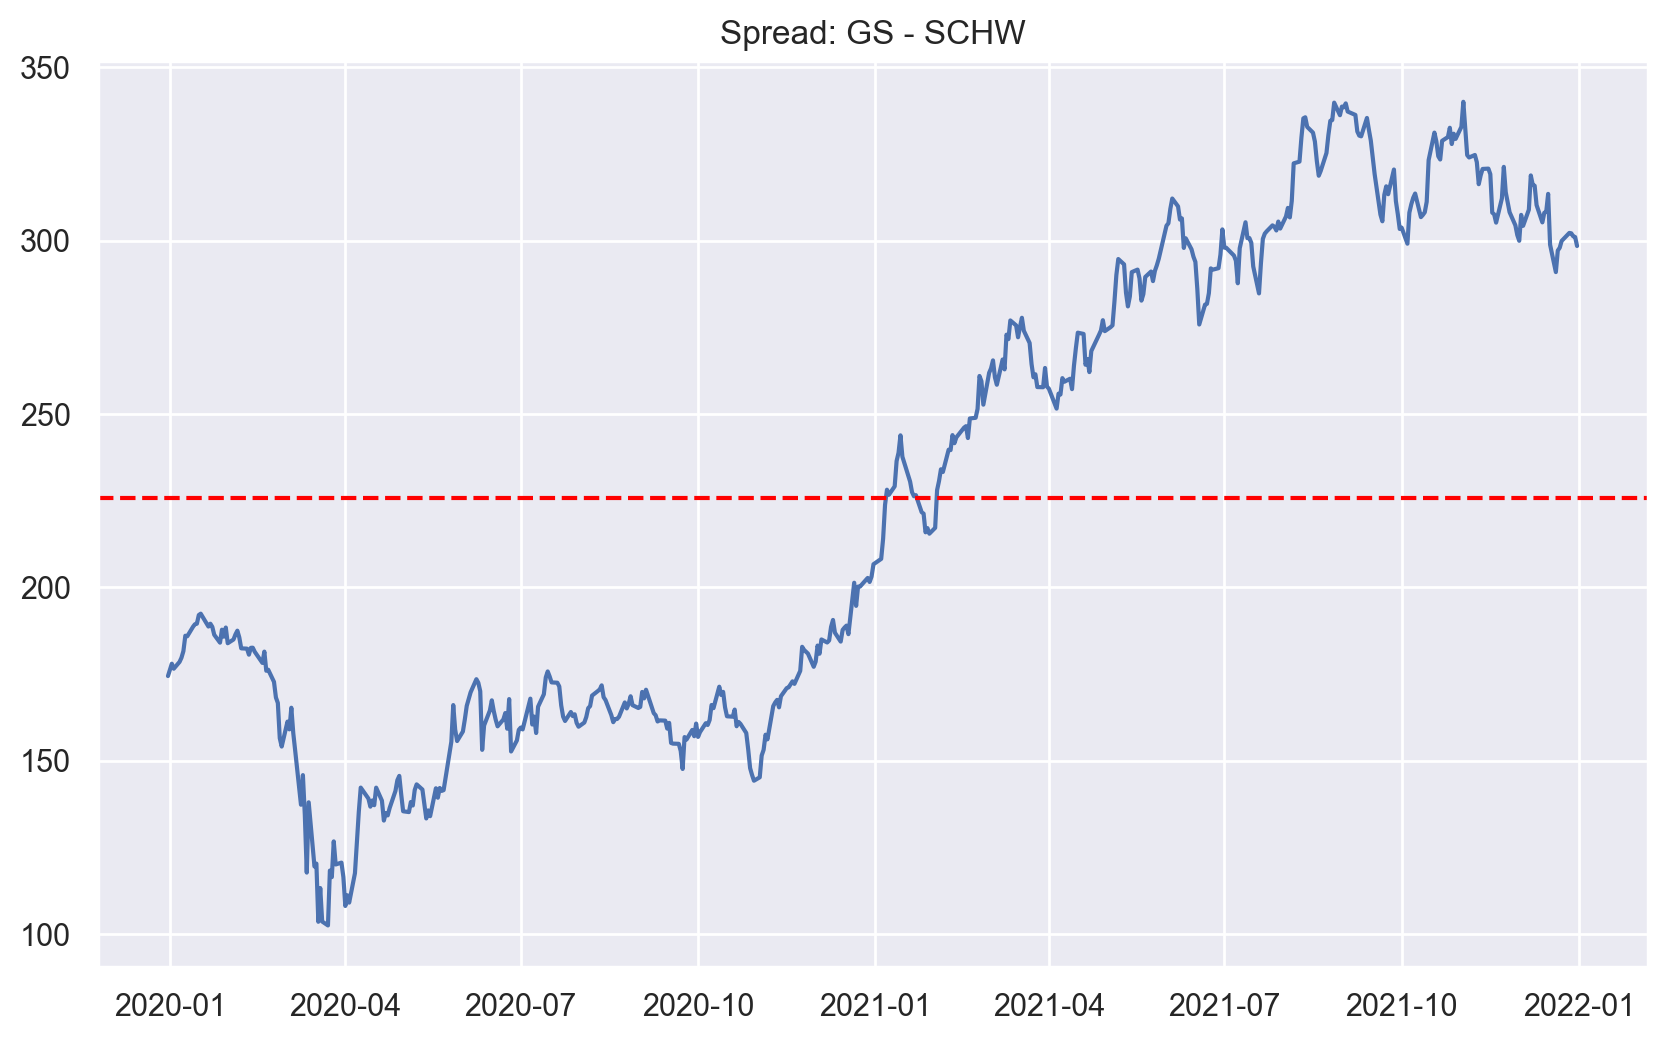

In [89]:
# plot the spread
plt.figure(figsize=(10, 6), dpi=200)
spread = GS-SCHW
spread.name = 'GS-SCHW'
plt.plot(spread)

# Add the mean
plt.axhline(spread.mean(), color='red', linestyle='--') 
plt.title("Spread: GS - SCHW")
plt.show();

### Cointegration and Stationarity

Looking at the above plot of the spread, we now come to discuss the importance of stationarity to a pairs trading strategy. 

A time series is defined as sationary in mathematics and statistics when the parameters of the data generating process do not change over time. This means that it's mean and standard deviation remain constant. If the mean of a spread is dynamic, the mean reversion pairs trading strategy will fail. 

Cointegration is defined as follows: For some set of time series ($X_1$, $X_2$, $\dots$, $X_k$), if all series are $I(1)$, and some linear combination of them is $I(0)$, we say the set of time series is cointegrated. In other wards, if a linear combination of non-stationary variables is stationary, then they are cointegrated.

To test for a stationary spread, we can conduct statistical tests like the `Engle-Granger` for a multi-variate time series or the `Augmented Dickey Fuller` test for a uni-variate time series.

#### GS-SCHW Spread
The spread between GS-SCHW looks like it's following a increasing trend and does not look stationary. Since the computed mean shows the mean of all data points at a certain snapshot in time, it is meaningless to use this mean to forecast future price movements if its dynamic. Thus, we require the spread to be stationary to do apply meaningful mean reversion strategy.

#### Engle Grager Test

In [98]:
def engleGrangerTest(S1, S2, cutoff=0.05):
    """This function discerns if 2 variables are cointegrated by the Engle Granger Test"""
    result = coint(S1, S2)
    score, pvalue, _ = result
    
    if pvalue < cutoff:
        print(f'p-value = {pvalue}. Hence there likely exists a linear combination of the 2 series, {S1.name} and {S2.name}, that are stationary.')
    else:
        print(f'p-value = {pvalue}. Hence there likely does not exist a linear combination of the 2 series, {S1.name} and {S2.name}, that are stationary.')

engleGrangerTest(GS, SCHW)

p-value = 0.2657588611991566. Hence there likely does not exist a linear combination of the 2 series, GS and SCHW, that are stationary.


#### Augemented Dickey Fuller Test

In [97]:
def adf(S, cutoff=0.05):
    """This function discerns if a series is stationary of non-stationary by ADF"""
    pvalue = adfuller(S)[1]

    if pvalue < cutoff:
        print(f'p-value = {pvalue}. Hence the series, {S.name} is likely stationary.')
    else:
        print(f'p-value = {pvalue}. Hence the series, {S.name} is likely non-stationary.')

adf(spread)

p-value = 0.0031151518999445334. Hence the series, TFC-CFG is likely stationary.


Since the spread between GS and SCHW are not cointegrated and non-stationary by both our tests, we cannot implement a pairs trading strategy on said pair and need to look for another applicable pair to trade on.

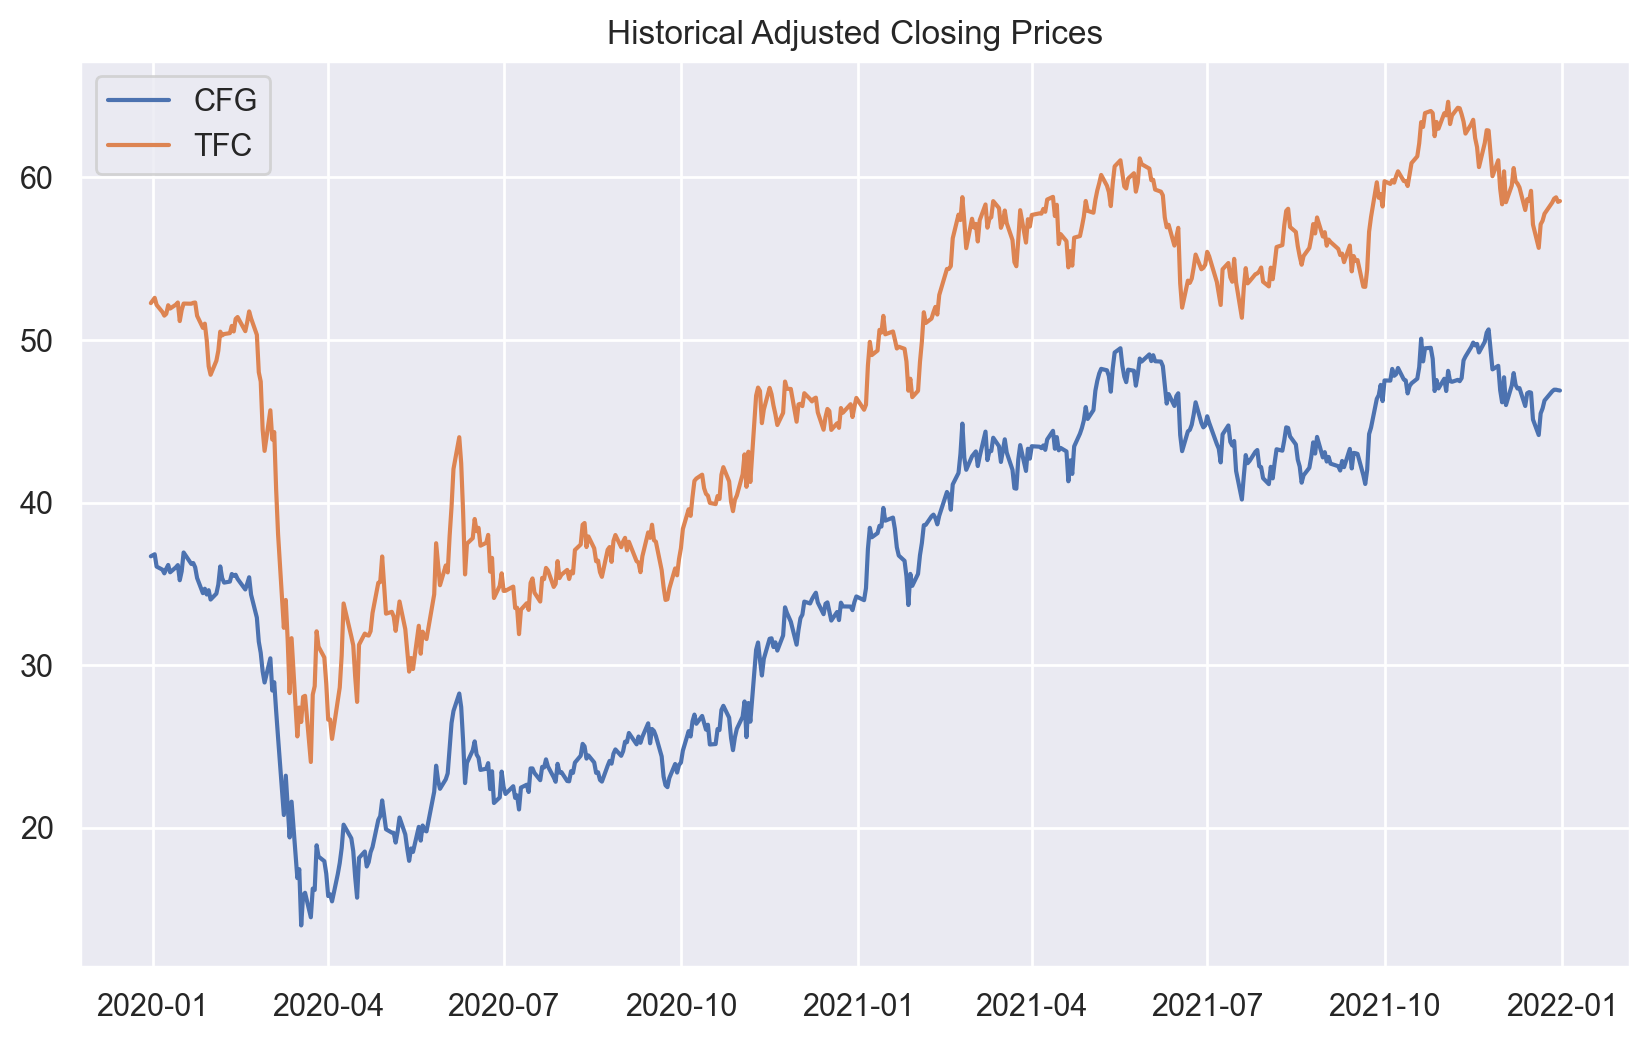

In [93]:
# High correlation between CFG and TFC of ~ 0.93
plt.figure(figsize=(10, 6), dpi=200)
CFG = prices['CFG']
TFC = prices['TFC']
plt.plot(CFG, label = 'CFG')
plt.plot(TFC, label = 'TFC')
plt.title('Historical Adjusted Closing Prices')
plt.legend()
plt.show();

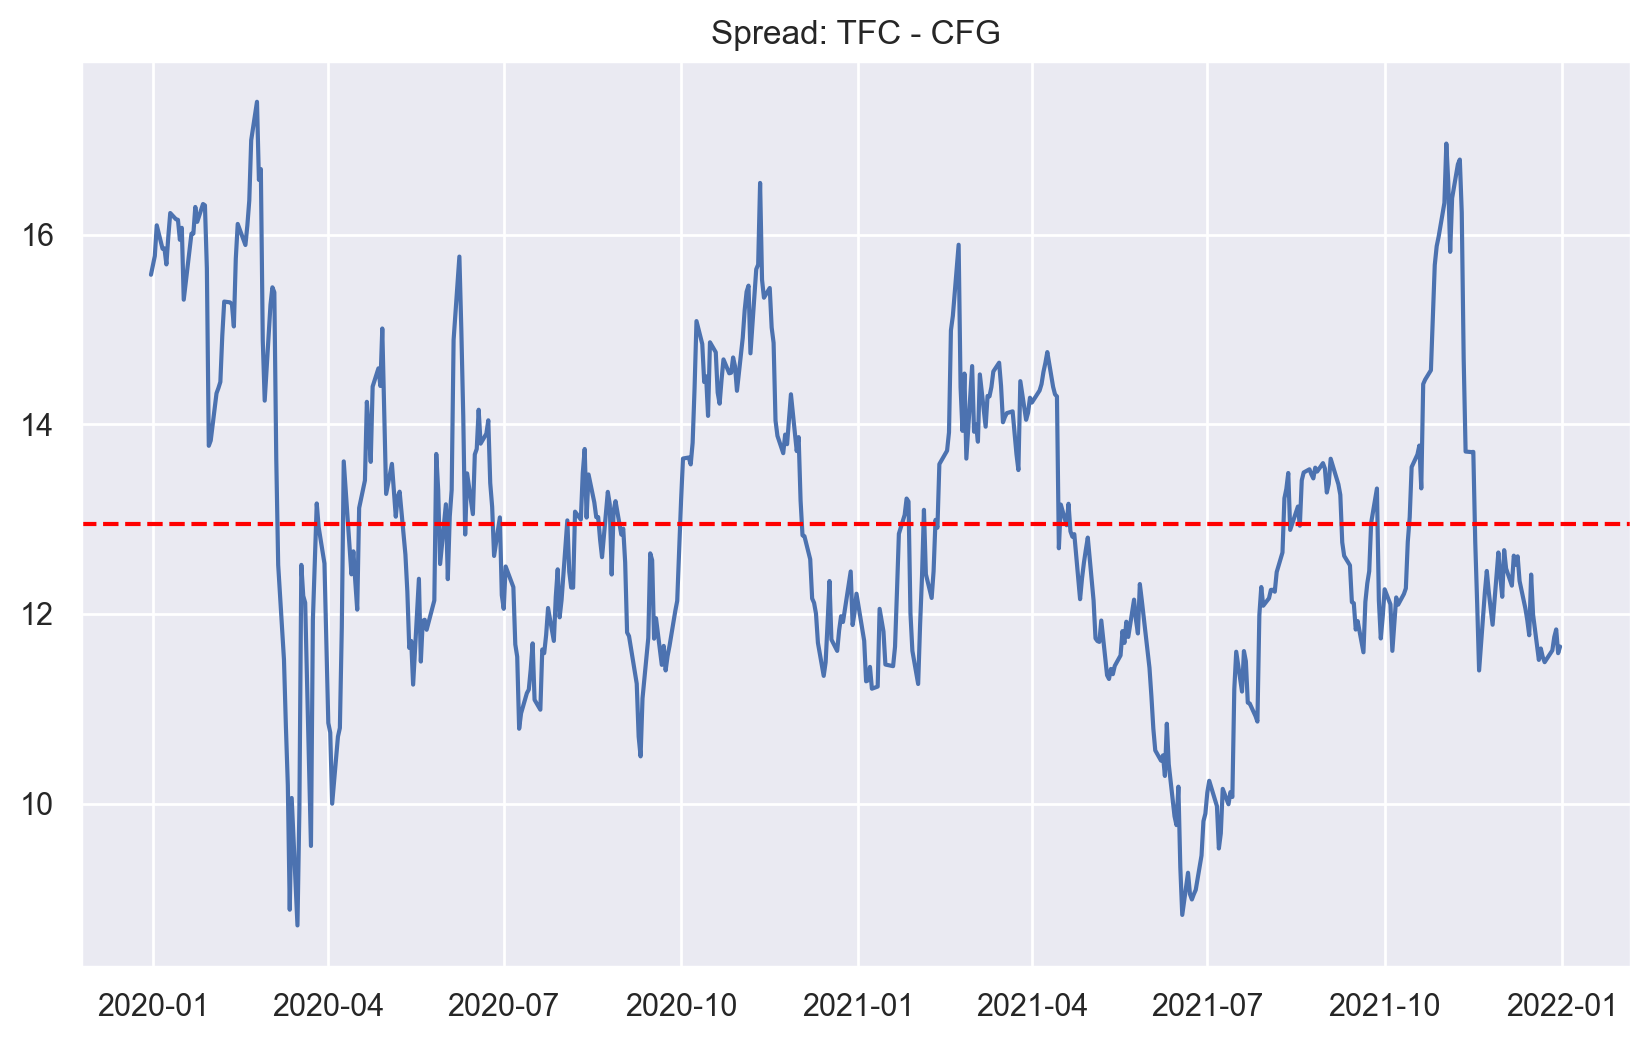

In [94]:
# plot the spread
plt.figure(figsize=(10, 6), dpi=200)
spread = TFC - CFG
spread.name = 'TFC-CFG'
plt.plot(spread)

# Add the mean
plt.axhline(spread.mean(), color='red', linestyle='--') 
plt.title("Spread: TFC - CFG")
plt.show();

This time the spread looks a lot more stationary. But we have to prove it statistically.

Similarly, we conduct our cointegration tests to check for stationarity on the TFC-CFG spread.

In [95]:
engleGrangerTest(TFC, CFG)

p-value = 0.013796950430554534. Hence there likely exists a linear combination of the 2 series, TFC and CFG, that are stationary.


In [96]:
adf(spread)

p-value = 0.0031151518999445334. Hence the series, TFC-CFG is likely stationary.


An interesting point to note is that the time series of `TFC` and `CFG` are clearly non-stationary but when combined, form a stationary time series. This statistical property is known as <b>cointegration</b> and implies that two or more non-stationary time series can be linearly combined to form a stationary one. 

Since the linear combination between TFC and CFG, the spread, varies around a mean, they are equity securities with cointegrated time series. 

The statistical tests above signifies stationarity in the spread between `TFC` and `CFG`. This implies that the spread `TFC-CFG` follows a set probability distribution which we can place bets on, using specifically the mean of the spread to create trading signals.

## Goal 2: Building Model Based on Statistical Analysis

Now that we have defined a pair of assets (TFC, CFG) whose spread is stationary by our cointegration tests defined above, we need to standardize the spread as the absolute spread might not be normally distributed, which can lead to skewed statistical analysis. W

We thus use z-scores (no. of standard deviations a datapoint is from the mean) to generate trading signals for our trading strategy - specfically trading signals of when to long/short the spread.

$$\mathcal{z}_{i}=\frac{x_{i}-\bar{x}}{s} $$

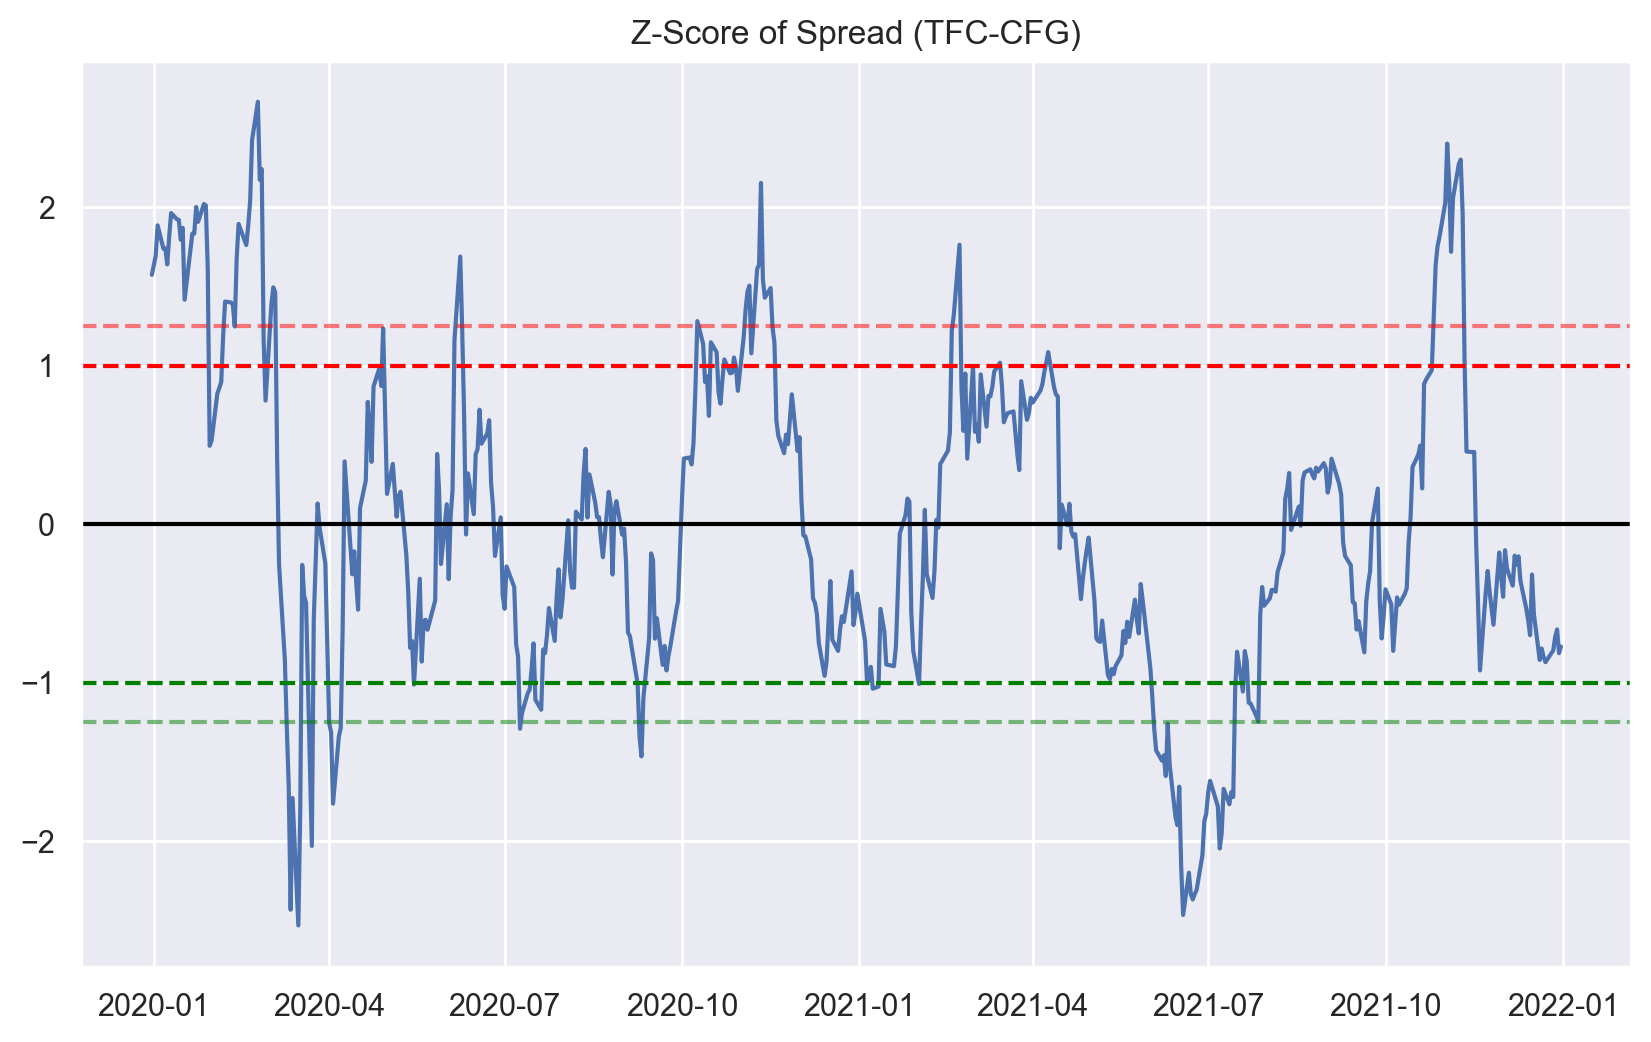

In [107]:
def zscore(S):
    return (S - S.mean()) / np.std(S)

plt.figure(figsize=(10,6), dpi=200)
plt.plot(zscore(spread))
plt.axhline(df_zscore.mean(), color = 'black')

# Setting the upper and lower bounds to be the z score of 1 and -1 where 68% of our data will lie between
plt.axhline(1.0, color='red', linestyle='--') 
plt.axhline(-1.0, color='green', linestyle='--') 

# 95% of our data will lie between these bounds
plt.axhline(1.25, color='red', alpha=0.5, linestyle='--') 
plt.axhline(-1.25, color='green',alpha=0.5, linestyle='--')
plt.title('Z-Score of Spread (TFC-CFG)')
plt.show();

By setting 4 other lines placed at the z-score of 1 and -1, 1.25, -1.25, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This helps us determine when and what bets to place.

1. <b>Long the spread (long TFC, short CFG) when it falls below the green lines.</b> 
2. <b>Short the spread (short TFC, long CFG) when it falls below the green lines.</b>

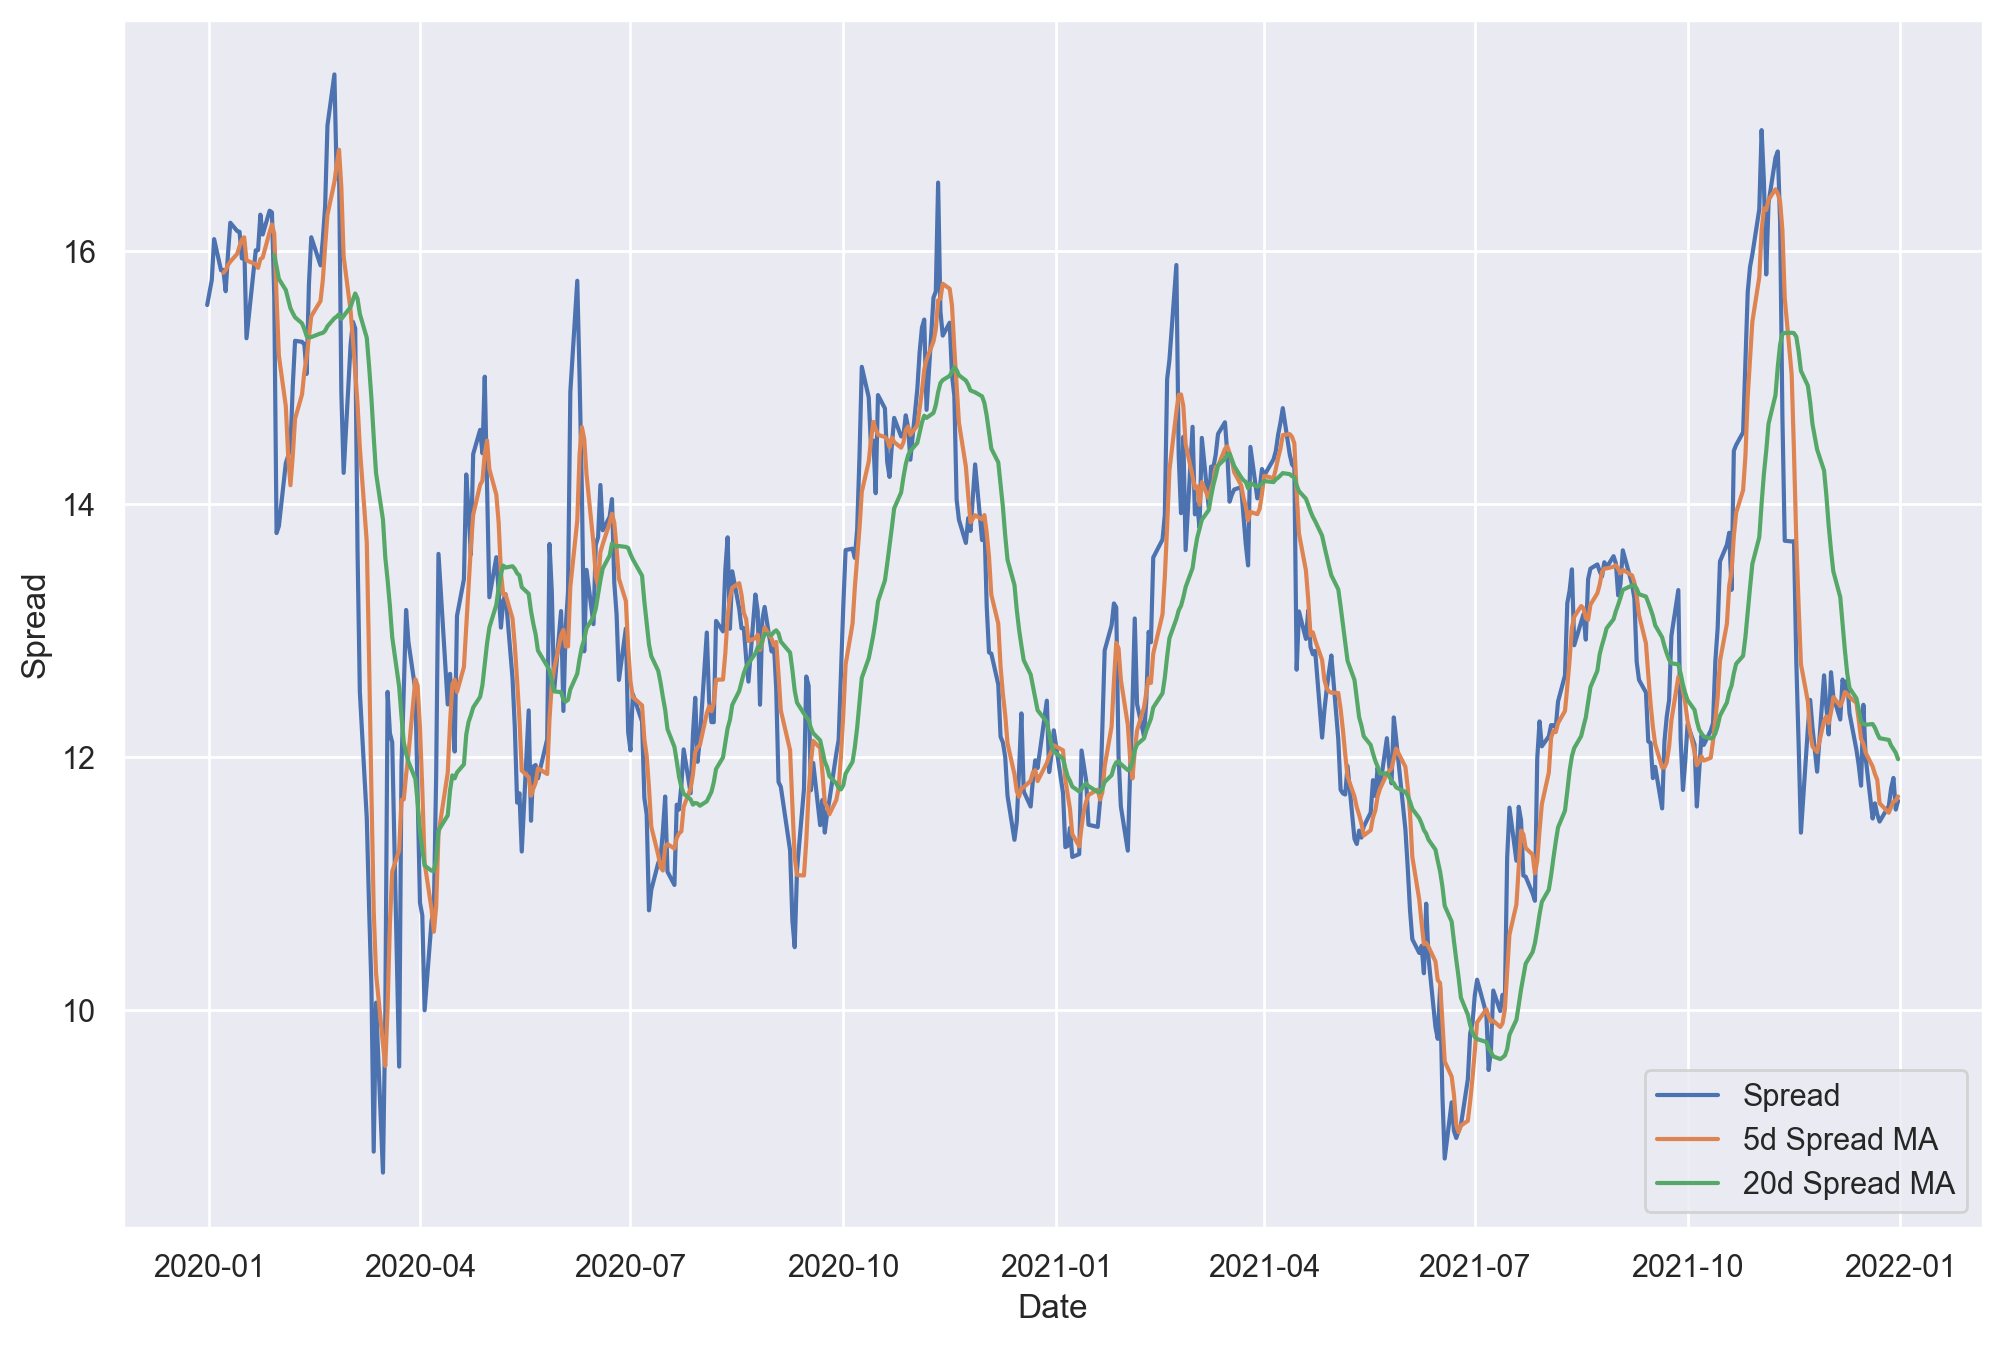

In [117]:
plt.figure(figsize=(12, 8), dpi=200)
spreads_mavg5 = spread.rolling(window=5, center=False).mean()
spreads_mavg20 = spread.rolling(window=20, center=False).mean()
plt.plot(spread.index, spread.values)
plt.plot(spreads_mavg5.index, spreads_mavg5.values)
plt.plot(spreads_mavg20.index, spreads_mavg20.values)
plt.legend(['Spread', '5d Spread MA', '20d Spread MA'])
plt.xlabel('Date')
plt.ylabel('Spread')
plt.show()

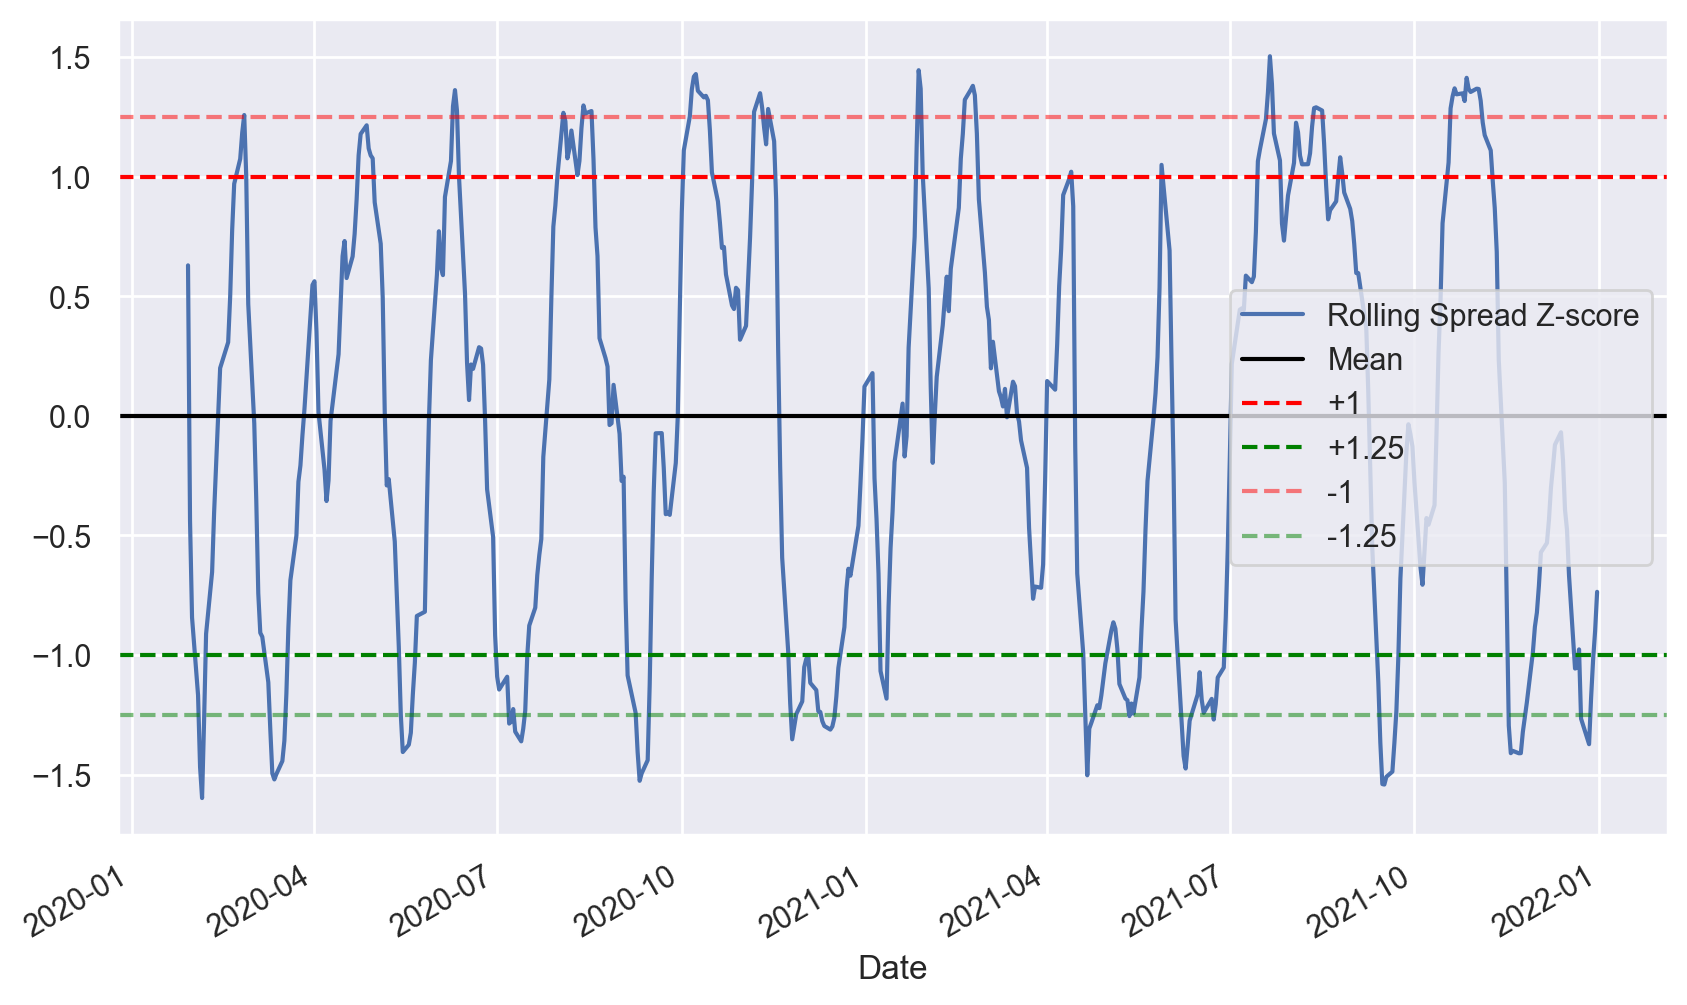

In [121]:
plt.figure(figsize=(10, 6), dpi=200)

std_20 = spread.rolling(window=20, center=False).std()
zscore_20_5 = (spreads_mavg5 - spreads_mavg20)/std_20
zscore_20_5.plot()

plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')

plt.axhline(1.25, color='red', alpha=0.5, linestyle='--')
plt.axhline(-1.25, color='green', alpha=0.5, linestyle='--')

plt.legend(['Rolling Spread Z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

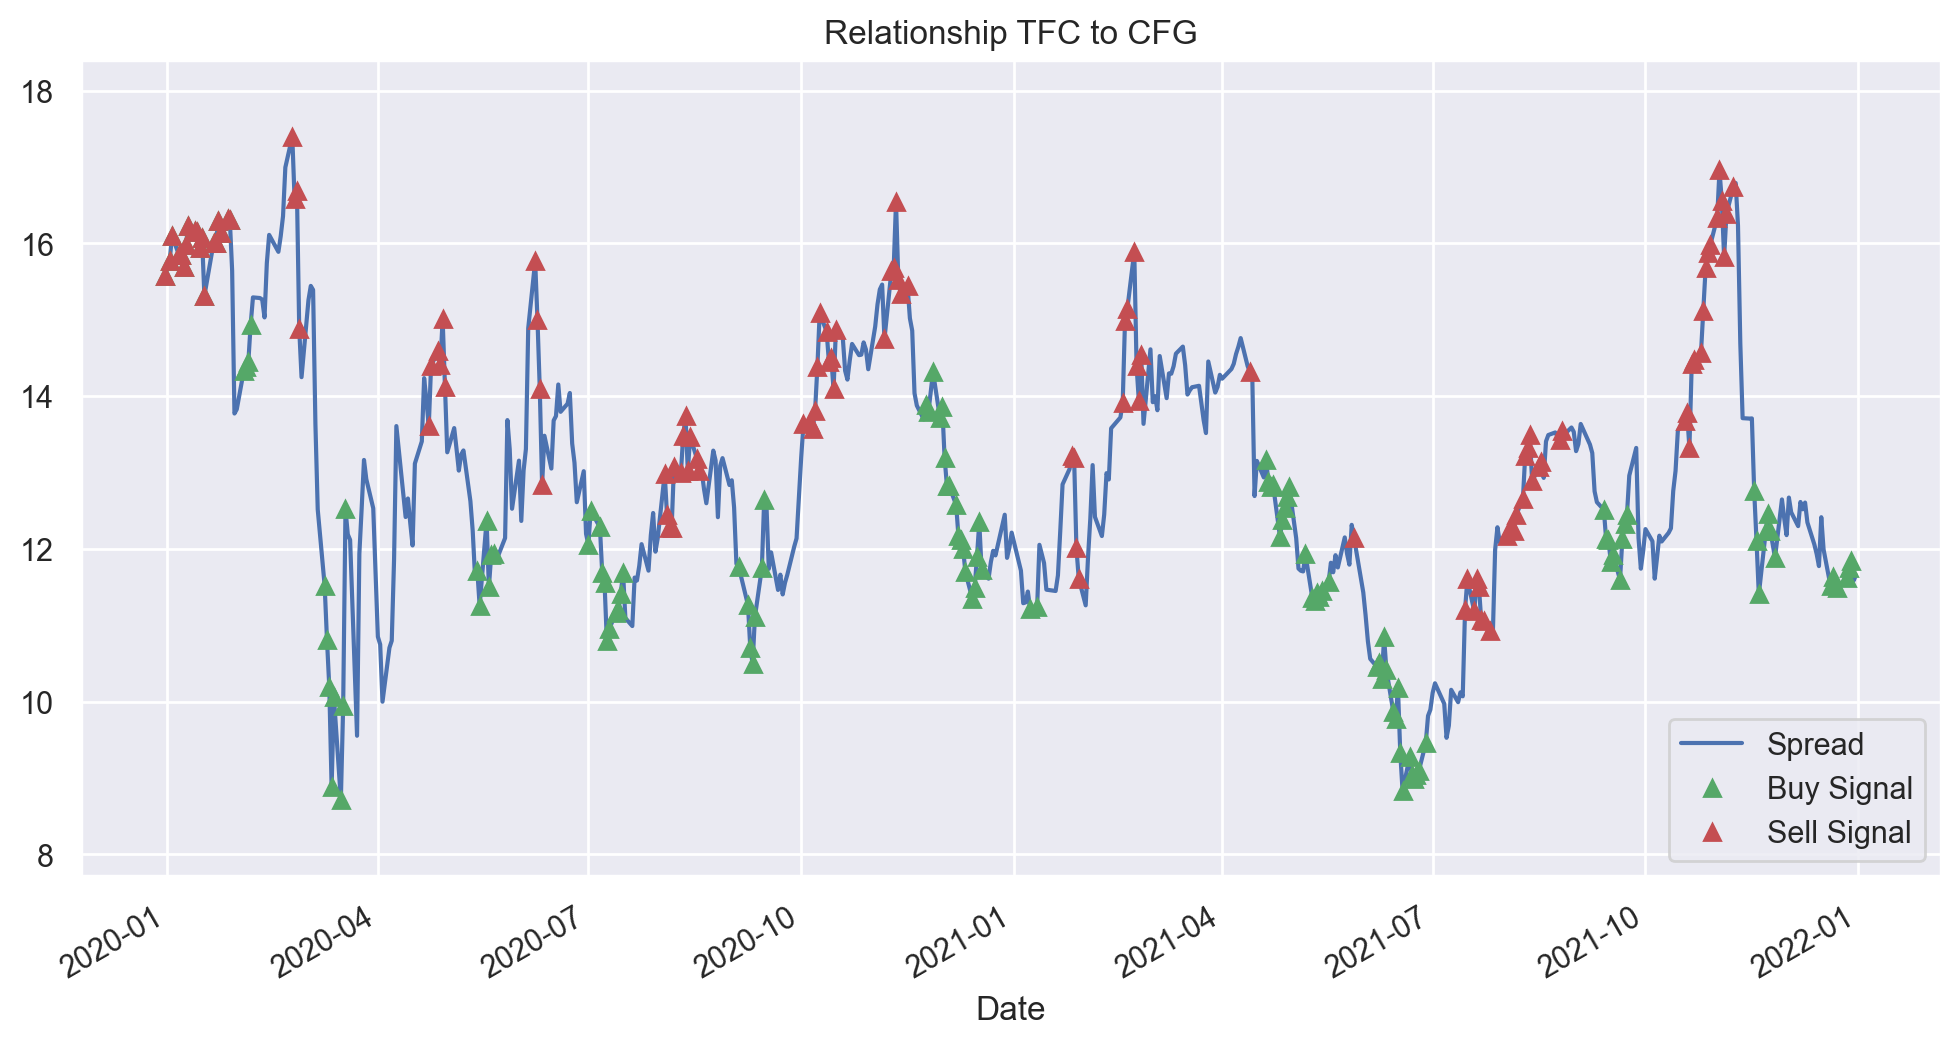

In [122]:
plt.figure(figsize=(12, 6), dpi=200)
spread.plot()

buy = spread.copy()
sell = spread.copy()

buy[zscore_20_5>-1] = 0 # Long TFC, short CFG
sell[zscore_20_5<1] = 0 # Short TFC, long CFG

buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, spread.min()-1, spread.max()+1))
plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship TFC to CFG')
plt.show()

## Areas for improvement

1. Backtesting strategy
2. Calculating spread using OLS